In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [4]:
mse_result_mean_baseline = {
    "Chicago":24207704.96397773,
    "Dallas":103053946.00059289,
    "Los Angeles":377293240.89948076,
    "New York":76662955.16487668,
    "Seattle":492230546.0705847
}

In [5]:
# Bad features we learn from feature importance analysis
good_features =[
 'City',
 'Date',
 'ZHVI',
 'Population_In_Housing_Units',
 'Renter-Occupied-Population',
 'OOP_Moved_From_Abroad',
 'passenger_domestic_inbound',
 'cargo_intl_outbound',
 'passenger_intl_outbound',
 'passenger_intl_inbound',
 'CBRE_Low',
 'CBRE_Close',
 'CBRE_Adj Close',
 'EQR_Close',
 'EQR_Adj Close',
 'RDFN_Low',
 'RDFN_Close']

In [6]:
# Load all feature data
merged_df_all_feature = pd.read_csv('/content/drive/MyDrive/MADS Capstone Team 23/Data/processed/merged.csv')
merged_df_all_feature.columns

Index(['City', 'Date', 'ZHVI', 'NewHomePermits', 'Population_In_Housing_Units',
       'Owner_Occupied_Population', 'Renter-Occupied-Population',
       'OOP_Moved_From_Different_County', 'OOP_Moved_From_Different_State',
       'OOP_Moved_From_Abroad', 'ROP_Moved_From_Different_County',
       'ROP_Moved_From_Different_State', 'ROP_Moved_From_Abroad',
       'PropertyCrimeIncident', 'ViolentCrimeIncident',
       'cargo_domestic_outbound', 'cargo_domestic_inbound',
       'passenger_domestic_outbound', 'passenger_domestic_inbound',
       'cargo_intl_outbound', 'cargo_intl_inbound', 'passenger_intl_outbound',
       'passenger_intl_inbound', 'dem_senate_cnt', 'rep_senate_cnt',
       'dem_house_cnt', 'rep_house_cnt', 'other_senate_cnt', 'other_house_cnt',
       'dem_spons_legis_cnt', 'rep_spons_legis_cnt', 'other_spons_legis_cnt',
       'dem_cospons_legis_cnt', 'rep_cospons_legis_cnt',
       'other_cospons_legis_cnt', 'days_with_thunderstorms', 'precipitation',
       'relative_hum

In [7]:
# Remove the bad features
merged_df_filtered_feature = merged_df_all_feature[good_features]
merged_df_filtered_feature.columns

Index(['City', 'Date', 'ZHVI', 'Population_In_Housing_Units',
       'Renter-Occupied-Population', 'OOP_Moved_From_Abroad',
       'passenger_domestic_inbound', 'cargo_intl_outbound',
       'passenger_intl_outbound', 'passenger_intl_inbound', 'CBRE_Low',
       'CBRE_Close', 'CBRE_Adj Close', 'EQR_Close', 'EQR_Adj Close',
       'RDFN_Low', 'RDFN_Close'],
      dtype='object')

# <h1><center> Train a LSTM model with all good features

In [6]:
# Function to process the data
def preprocess_data(df, window=3):
    split_index = int(len(df) * 0.8)
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df.drop(['Date', 'City'], axis=1))
    test_scaled = scaler.transform(test_df.drop(['Date', 'City'], axis=1))

    X_train, y_train = [], []
    for i in range(window, len(train_scaled)):
        X_train.append(train_scaled[i-window:i])
        y_train.append(train_scaled[i, 0])  # ZHVI is the first column

    X_test, y_test = [], []
    for i in range(window, len(test_scaled)):
        X_test.append(test_scaled[i-window:i])
        y_test.append(test_scaled[i, 0])  # ZHVI is the first column

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), scaler

# Function to create and train LSTM
def create_and_train_lstm(X_train, y_train, epochs=100, batch_size=32):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

    return model, history

# Function to make predictions and inverse scale them
def make_predictions(model, X, scaler):
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], X.shape[2] - 1)))))
    return predictions[:, 0]  # Only return the ZHVI predictions

In [7]:
# Main execution
results = {}
cities = ["Chicago"]

for city in cities:
    city_data = merged_df_filtered_feature[merged_df_filtered_feature['City'] == city].reset_index(drop=True)
    results[city] = {}

    # Use Window size 3 as we know it's the best
    X_train, y_train, X_test, y_test, scaler = preprocess_data(city_data, window=3)

    # Train the model
    model, history = create_and_train_lstm(X_train, y_train)

    # Make predictions
    lstm_preds = make_predictions(model, X_test, scaler)
    actual_vals = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1)))))
    actual_vals = actual_vals[:, 0]

    # Calculate MSE
    mse = mean_squared_error(actual_vals, lstm_preds)
    results[city] = {'mse': mse, 'predictions': lstm_preds, 'actuals': actual_vals}
    print(f'{city} - MSE: {mse:.2f}')

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 277ms/step - loss: 0.1786 - val_loss: 0.6704
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1328 - val_loss: 0.5384
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0871 - val_loss: 0.4120
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0585 - val_loss: 0.2920
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0474 - val_loss: 0.1911
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0434 - val_loss: 0.1336
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0477 - val_loss: 0.1131
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0414 - val_loss: 0.1175
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0353 - val_loss: 0.1342
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0321 - val_loss: 0.1445
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0310 - val_loss: 0.1415
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0285 - val_loss: 0.1213


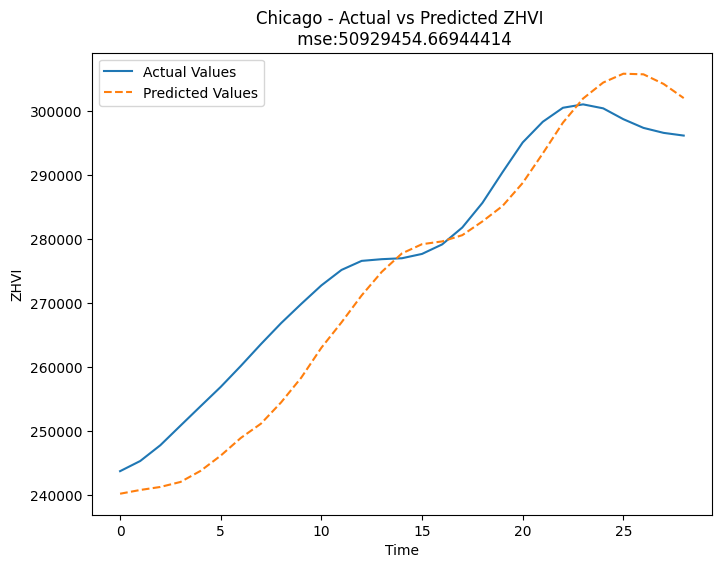

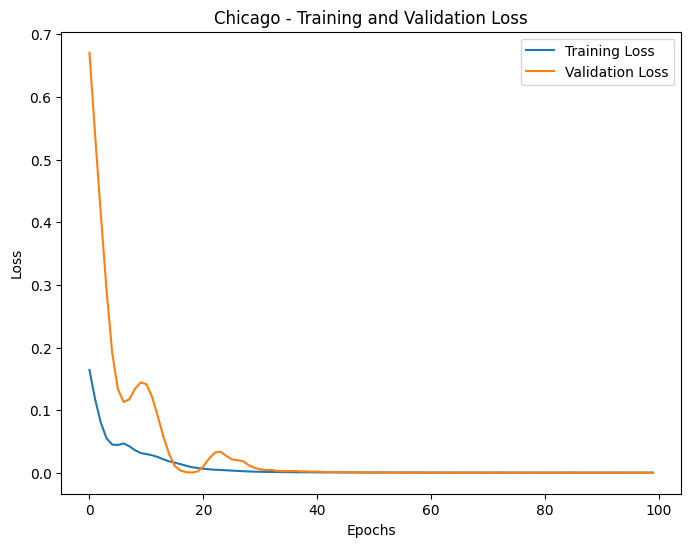

In [8]:
# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(results[city]['actuals'], label='Actual Values')
plt.plot(results[city]['predictions'], label='Predicted Values', linestyle='--')
plt.title(f"{city} - Actual vs Predicted ZHVI \n mse:{results[city]['mse']}")
plt.xlabel('Time')
plt.ylabel('ZHVI')
plt.legend()
plt.show()

# Plotting loss curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(f"{city} - Training and Validation Loss")
plt.show()

In [9]:
comparison_dict = {}
for city in cities:
  city_mse = results[city]['mse']
  percent_change = ((city_mse - mse_result_mean_baseline[city])/mse_result_mean_baseline[city])*100
  comparison_dict[city] = percent_change
  print(f"For {city}, the model with fewer features and 3 month window size performed {'better' if percent_change < 0 else 'worse'} by {abs(percent_change):.2f}%")

print("\nSummary of Performance Changes Comparing to Mean Baseline Model:")
print(comparison_dict)

For Chicago, the model with fewer features and 3 month window size performed worse by 110.39%

Summary of Performance Changes Comparing to Mean Baseline Model:
{'Chicago': 110.38530808777493}


# <h1><center>Hyperprameter Tuning

In [11]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.2 MB/s eta 0:00:00


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from kerastuner.tuners import RandomSearch
import shutil

# Remove the previous tuning directory
shutil.rmtree('hyperparam_tuning/lstm_tuning', ignore_errors=True)

# Filter data for Chicago only
city = "Chicago"
city_data = merged_df_filtered_feature[merged_df_filtered_feature['City'] == city].reset_index(drop=True)

# Function to preprocess the data
def preprocess_data(df, window=3):
    split_index = int(len(df) * 0.8)
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df.drop(['Date', 'City'], axis=1))
    test_scaled = scaler.transform(test_df.drop(['Date', 'City'], axis=1))

    X_train, y_train = [], []
    for i in range(window, len(train_scaled)):
        X_train.append(train_scaled[i-window:i])
        y_train.append(train_scaled[i, 0])  # ZHVI is the first column

    X_test, y_test = [], []
    for i in range(window, len(test_scaled)):
        X_test.append(test_scaled[i-window:i])
        y_test.append(test_scaled[i, 0])  # ZHVI is the first column

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), scaler

# Preprocess data
X_train, y_train, X_test, y_test, scaler = preprocess_data(city_data, window=3)

# Build model function
def build_model(hp):
    model = Sequential()
    # First LSTM layer with Dropout
    model.add(LSTM(units=hp.Int('units_layer1', min_value=50, max_value=200, step=50),
                   return_sequences=True,
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   kernel_regularizer=l2(hp.Float('l2_layer1', min_value=1e-4, max_value=1e-2, sampling='LOG'))))
    model.add(Dropout(rate=hp.Float('dropout_layer1', min_value=0.1, max_value=0.5, step=0.1)))

    # Second LSTM layer with Dropout
    model.add(LSTM(units=hp.Int('units_layer2', min_value=50, max_value=200, step=50),
                   kernel_regularizer=l2(hp.Float('l2_layer2', min_value=1e-4, max_value=1e-2, sampling='LOG'))))
    model.add(Dropout(rate=hp.Float('dropout_layer2', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, kernel_regularizer=l2(hp.Float('l2_output', min_value=1e-4, max_value=1e-2, sampling='LOG'))))

    # Compile model
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model

# Create tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=30,
    executions_per_trial=2,
    directory='hyperparam_tuning',
    project_name='lstm_tuning')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Run the tuner search with early stopping
tuner.search(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])

# Retrieve and print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]
print("Best Hyperparameters:")
print(f"Units Layer 1: {best_hyperparameters.get('units_layer1')}")
print(f"Units Layer 2: {best_hyperparameters.get('units_layer2')}")
print(f"L2 Regularization Layer 1: {best_hyperparameters.get('l2_layer1')}")
print(f"L2 Regularization Layer 2: {best_hyperparameters.get('l2_layer2')}")
print(f"L2 Regularization Output Layer: {best_hyperparameters.get('l2_output')}")
print(f"Dropout Layer 1: {best_hyperparameters.get('dropout_layer1')}")
print(f"Dropout Layer 2: {best_hyperparameters.get('dropout_layer2')}")
print(f"Learning Rate: {best_hyperparameters.get('learning_rate')}")

# Extracting and printing the performance of different hyperparameter combinations
trials = tuner.oracle.get_best_trials(num_trials=10)
trial_data = []

for trial in trials:
    trial_data.append({
        'units_layer1': trial.hyperparameters.values['units_layer1'],
        'units_layer2': trial.hyperparameters.values['units_layer2'],
        'l2_layer1': trial.hyperparameters.values['l2_layer1'],
        'l2_layer2': trial.hyperparameters.values['l2_layer2'],
        'l2_output': trial.hyperparameters.values['l2_output'],
        'dropout_layer1': trial.hyperparameters.values['dropout_layer1'],
        'dropout_layer2': trial.hyperparameters.values['dropout_layer2'],
        'learning_rate': trial.hyperparameters.values['learning_rate'],
        'val_loss': trial.metrics.get_best_value('val_loss')
    })

trial_df = pd.DataFrame(trial_data)
print("\nTop 10 Hyperparameter Combinations:")
print(trial_df)

Trial 1 Complete [00h 00m 52s]
val_loss: 0.004062610445544124

Best val_loss So Far: 0.004062610445544124
Total elapsed time: 00h 00m 52s
Best Hyperparameters:
Units Layer 1: 50
Units Layer 2: 100
L2 Regularization Layer 1: 0.00016825877967288082
L2 Regularization Layer 2: 0.0007696562425383041
L2 Regularization Output Layer: 0.008153809124911116
Dropout Layer 1: 0.4
Dropout Layer 2: 0.2
Learning Rate: 0.0039426799290831925

Top 10 Hyperparameter Combinations:
   units_layer1  units_layer2  l2_layer1  l2_layer2  l2_output  \
0            50           100   0.000168    0.00077   0.008154   

   dropout_layer1  dropout_layer2  learning_rate  val_loss  
0             0.4             0.2       0.003943  0.004063  


In [10]:
# Build and retrain the best model
best_model = build_model(best_hyperparameters)
history = best_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Function to make predictions and inverse scale them
def make_predictions(model, X, scaler):
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], X.shape[2] - 1)))))
    return predictions[:, 0]  # Only return the ZHVI predictions

# Make predictions using the best model
lstm_preds = make_predictions(best_model, X_test, scaler)

y_test_inverse = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1)))))
actual_vals = y_test_inverse[:, 0]

# Calculate MSE
mse = mean_squared_error(actual_vals, lstm_preds)
print(f'Test MSE: {mse:.2f}')


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.2166 - val_loss: 0.1386
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1386 - val_loss: 0.1934
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0959 - val_loss: 0.2006
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0901 - val_loss: 0.0544
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0685 - val_loss: 0.0539
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0570 - val_loss: 0.0396
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0541 - val_loss: 0.0353
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0422 - val_loss: 0.0577
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0398 - val_loss: 0.0568
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0379 - val_loss: 0.0319
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0358 - val_loss: 0.0386
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0321 - val_loss: 0.0377
Epo

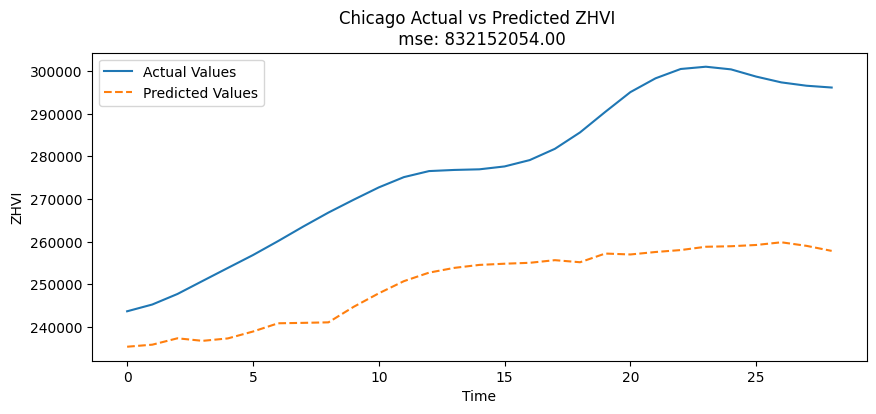

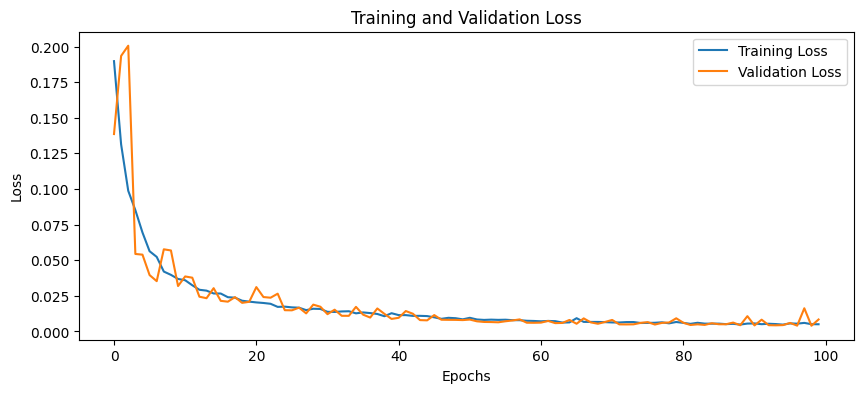

In [11]:

# Plotting the actual vs predicted results
plt.figure(figsize=(10, 4))
plt.plot(actual_vals, label='Actual Values')
plt.plot(lstm_preds, label='Predicted Values', linestyle='--')
plt.title(f"Chicago Actual vs Predicted ZHVI \n mse: {mse:.2f}")
plt.xlabel('Time')
plt.ylabel('ZHVI')
plt.legend()
plt.show()

# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [12]:
comparison_dict = {}
city = 'Chicago'
percent_change = ((mse - mse_result_mean_baseline[city])/mse_result_mean_baseline[city])*100
comparison_dict[city] = percent_change
print(f"For {city}, the model with fewer features and 3 month window size performed {'better' if percent_change < 0 else 'worse'} by {abs(percent_change):.2f}%")

print("\nSummary of Performance Changes Comparing to Mean Baseline Model:")
print(comparison_dict)

For Chicago, the model with fewer features and 3 month window size performed worse by 3337.55%

Summary of Performance Changes Comparing to Mean Baseline Model:
{'Chicago': 3337.550380073889}
